# Topic 2: Prior Distributions and Bayes Theorem

## Learning Objectives
- Understand different types of prior distributions
- Master conjugate priors and their computational advantages
- Learn about non-informative and improper priors
- Apply prior elicitation techniques
- Understand the impact of prior choice on posterior inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import arviz as az
from scipy.special import gamma, beta as beta_func

plt.style.use('seaborn-v0_8')
np.random.seed(42)

## 1. Types of Prior Distributions

### Classification by Information Content:

1. **Informative Priors**: Contain substantial information about the parameter
2. **Weakly Informative Priors**: Provide some constraint but allow data to dominate
3. **Non-informative Priors**: Attempt to be "objective" or "neutral"
4. **Improper Priors**: Don't integrate to 1 (may still yield proper posteriors)

### Classification by Mathematical Properties:

1. **Conjugate Priors**: Result in posterior from same family as prior
2. **Non-conjugate Priors**: Require numerical methods for posterior computation

**To do:**

```Emperical Prioirs``` : ....

## 2. Conjugate Priors - Mathematical Elegance

### Definition
A prior distribution is **conjugate** to a likelihood if the posterior distribution belongs to the same family as the prior.

### Key Conjugate Pairs:

| Likelihood | Parameter | Conjugate Prior | Posterior |
|------------|-----------|-----------------|----------|
| Binomial | p | Beta(α, β) | Beta(α + x, β + n - x) |
| Poisson | λ | Gamma(α, β) | Gamma(α + Σx, β + n) |
| Normal (known σ²) | μ | Normal(μ₀, σ₀²) | Normal(...) |
| Normal (known μ) | σ² | Inverse-Gamma | Inverse-Gamma |

### Beta-Binomial Example

**Prior**: $p \sim \text{Beta}(\alpha, \beta)$

**Likelihood**: $X|p \sim \text{Binomial}(n, p)$

**Posterior**: $p|X \sim \text{Beta}(\alpha + x, \beta + n - x)$

```Effects of Conjugate Priors in ML```

```Properties of Priors```

```Computational Complexity```

Example 1: Weak Prior (Beta(1,1) = Uniform)


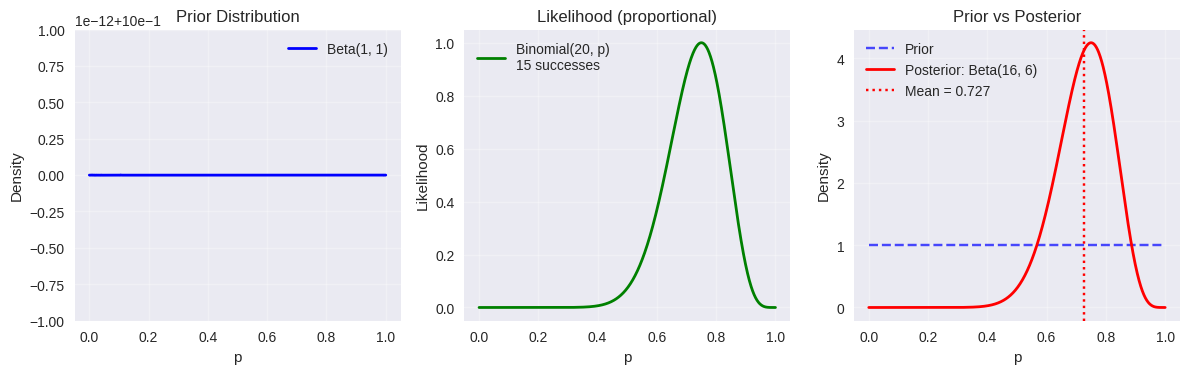

Prior: Beta(1, 1)
Data: 15 successes in 20 trials
Posterior: Beta(16, 6)
Prior mean: 0.500
Posterior mean: 0.727
MLE: 0.750


Example 2: Strong Prior (Beta(10,2))


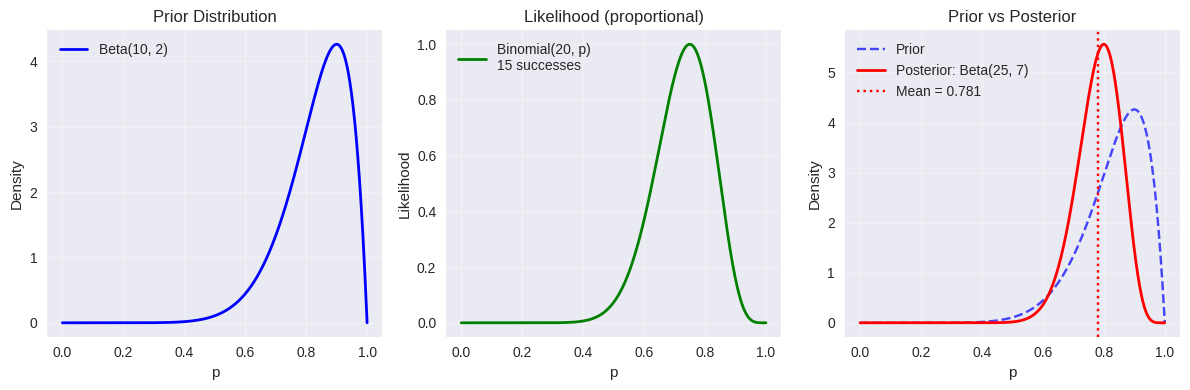

Prior: Beta(10, 2)
Data: 15 successes in 20 trials
Posterior: Beta(25, 7)
Prior mean: 0.833
Posterior mean: 0.781
MLE: 0.750


In [2]:
# Demonstrate Beta-Binomial conjugacy
def plot_beta_binomial_conjugacy(alpha_prior, beta_prior, n_trials, n_successes):
    """
    Visualize Beta-Binomial conjugacy
    """
    x = np.linspace(0, 1, 1000)
    
    # Prior
    prior = stats.beta(alpha_prior, beta_prior)
    
    # Posterior parameters
    alpha_post = alpha_prior + n_successes
    beta_post = beta_prior + n_trials - n_successes
    posterior = stats.beta(alpha_post, beta_post)
    
    # Likelihood (proportional)
    likelihood_prop = x**n_successes * (1-x)**(n_trials - n_successes)
    likelihood_prop /= np.max(likelihood_prop)  # Normalize for plotting
    
    plt.figure(figsize=(12, 4))
    
    # Plot components
    plt.subplot(1, 3, 1)
    plt.plot(x, prior.pdf(x), 'b-', linewidth=2, label=f'Beta({alpha_prior}, {beta_prior})')
    plt.title('Prior Distribution')
    plt.xlabel('p')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(x, likelihood_prop, 'g-', linewidth=2, 
             label=f'Binomial({n_trials}, p)\n{n_successes} successes')
    plt.title('Likelihood (proportional)')
    plt.xlabel('p')
    plt.ylabel('Likelihood')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(x, prior.pdf(x), 'b--', alpha=0.7, label='Prior')
    plt.plot(x, posterior.pdf(x), 'r-', linewidth=2, 
             label=f'Posterior: Beta({alpha_post}, {beta_post})')
    plt.axvline(posterior.mean(), color='red', linestyle=':', 
               label=f'Mean = {posterior.mean():.3f}')
    plt.title('Prior vs Posterior')
    plt.xlabel('p')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Prior: Beta({alpha_prior}, {beta_prior})")
    print(f"Data: {n_successes} successes in {n_trials} trials")
    print(f"Posterior: Beta({alpha_post}, {beta_post})")
    print(f"Prior mean: {prior.mean():.3f}")
    print(f"Posterior mean: {posterior.mean():.3f}")
    print(f"MLE: {n_successes/n_trials:.3f}")

# Example 1: Weak prior
print("Example 1: Weak Prior (Beta(1,1) = Uniform)")
plot_beta_binomial_conjugacy(1, 1, 20, 15)

print("\n" + "="*50 + "\n")

# Example 2: Strong prior
print("Example 2: Strong Prior (Beta(10,2))")
plot_beta_binomial_conjugacy(10, 2, 20, 15)

## 3. Gamma-Poisson Conjugacy

**Prior**: $\lambda \sim \text{Gamma}(\alpha, \beta)$

**Likelihood**: $X_i|\lambda \sim \text{Poisson}(\lambda)$

**Posterior**: $\lambda|X \sim \text{Gamma}(\alpha + \sum x_i, \beta + n)$

Observed data: [23 18 25 22 19 24 21 26 20 23]
Total visits in 10 hours: 221
Sample mean: 22.10 visits/hour

Prior: Gamma(2, 0.1)
Prior mean: 20.0 visits/hour

Posterior: Gamma(223, 10.1)
Posterior mean: 22.08 visits/hour


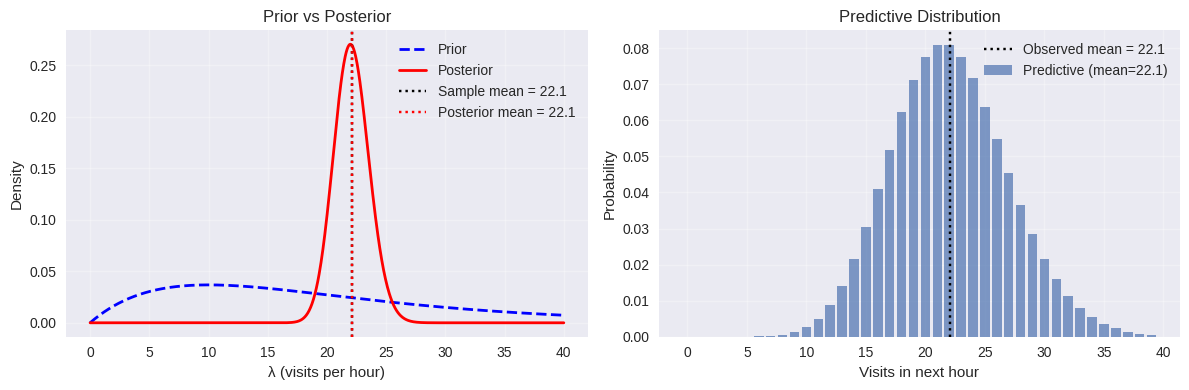


95% Credible Interval for λ: [19.28, 25.07]
Probability λ > 25: 0.028


In [3]:
# Gamma-Poisson conjugacy example: Website visits per hour
# Data: hourly website visits
visits_per_hour = np.array([23, 18, 25, 22, 19, 24, 21, 26, 20, 23])
n_hours = len(visits_per_hour)
total_visits = np.sum(visits_per_hour)

print(f"Observed data: {visits_per_hour}")
print(f"Total visits in {n_hours} hours: {total_visits}")
print(f"Sample mean: {np.mean(visits_per_hour):.2f} visits/hour")

# Prior: Gamma(2, 0.1) - weakly informative
alpha_prior, beta_prior = 2, 0.1
prior_mean = alpha_prior / beta_prior
print(f"\nPrior: Gamma({alpha_prior}, {beta_prior})")
print(f"Prior mean: {prior_mean:.1f} visits/hour")

# Posterior
alpha_post = alpha_prior + total_visits
beta_post = beta_prior + n_hours
posterior_mean = alpha_post / beta_post

print(f"\nPosterior: Gamma({alpha_post}, {beta_post:.1f})")
print(f"Posterior mean: {posterior_mean:.2f} visits/hour")

# Visualization
x = np.linspace(0, 40, 1000)
prior_dist = stats.gamma(alpha_prior, scale=1/beta_prior)
posterior_dist = stats.gamma(alpha_post, scale=1/beta_post)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, prior_dist.pdf(x), 'b--', linewidth=2, label='Prior')
plt.plot(x, posterior_dist.pdf(x), 'r-', linewidth=2, label='Posterior')
plt.axvline(np.mean(visits_per_hour), color='black', linestyle=':', 
           label=f'Sample mean = {np.mean(visits_per_hour):.1f}')
plt.axvline(posterior_mean, color='red', linestyle=':', 
           label=f'Posterior mean = {posterior_mean:.1f}')
plt.xlabel('λ (visits per hour)')
plt.ylabel('Density')
plt.title('Prior vs Posterior')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictive distribution for next hour
plt.subplot(1, 2, 2)
# Negative binomial is the predictive distribution for Gamma-Poisson
x_pred = np.arange(0, 40)
# Convert Gamma parameters to negative binomial parameters
r = alpha_post
p = beta_post / (beta_post + 1)
pred_dist = stats.nbinom(r, p)

plt.bar(x_pred, pred_dist.pmf(x_pred), alpha=0.7, 
        label=f'Predictive (mean={pred_dist.mean():.1f})')
plt.axvline(np.mean(visits_per_hour), color='black', linestyle=':', 
           label=f'Observed mean = {np.mean(visits_per_hour):.1f}')
plt.xlabel('Visits in next hour')
plt.ylabel('Probability')
plt.title('Predictive Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Credible interval
ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
print(f"\n95% Credible Interval for λ: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Probability of exceeding threshold
threshold = 25
prob_exceed = 1 - posterior_dist.cdf(threshold)
print(f"Probability λ > {threshold}: {prob_exceed:.3f}")

## 4. Normal-Normal Conjugacy

For Normal likelihood with known variance σ²:

**Prior**: $\mu \sim N(\mu_0, \sigma_0^2)$

**Likelihood**: $X_i|\mu \sim N(\mu, \sigma^2)$

**Posterior**: $\mu|X \sim N(\mu_n, \sigma_n^2)$

Where:
- $\sigma_n^2 = \frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}}$
- $\mu_n = \sigma_n^2 \left(\frac{\mu_0}{\sigma_0^2} + \frac{n\bar{x}}{\sigma^2}\right)$

Sample data: [175 168 172 180 165 177 170 174 169 176]
Sample mean: 172.60 cm
Sample size: 10
Known σ: 5 cm

Prior: N(170, 10²)
Posterior: N(172.54, 1.56²)


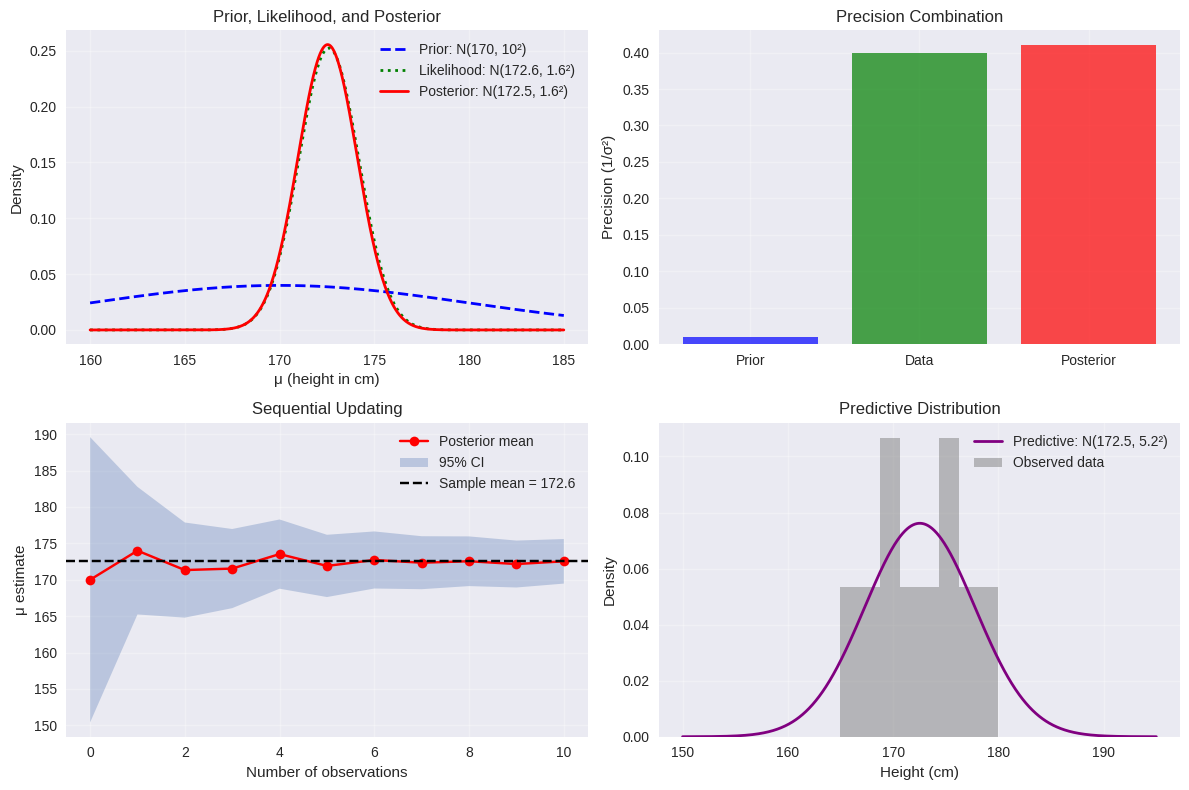


95% Credible Interval for μ: [169.48, 175.60] cm
95% Prediction Interval for new height: [162.27, 182.80] cm


In [4]:
# Normal-Normal conjugacy: Estimating average height
# Data: heights in cm
heights = np.array([175, 168, 172, 180, 165, 177, 170, 174, 169, 176])
n = len(heights)
x_bar = np.mean(heights)
sigma_known = 5  # Assume known standard deviation

print(f"Sample data: {heights}")
print(f"Sample mean: {x_bar:.2f} cm")
print(f"Sample size: {n}")
print(f"Known σ: {sigma_known} cm")

# Prior: μ ~ N(170, 10²)
mu_0 = 170
sigma_0 = 10

print(f"\nPrior: N({mu_0}, {sigma_0}²)")

# Posterior calculations
precision_prior = 1 / sigma_0**2
precision_data = n / sigma_known**2
precision_post = precision_prior + precision_data
sigma_n = 1 / np.sqrt(precision_post)

mu_n = (precision_prior * mu_0 + precision_data * x_bar) / precision_post

print(f"Posterior: N({mu_n:.2f}, {sigma_n:.2f}²)")

# Visualization
x = np.linspace(160, 185, 1000)
prior_dist = stats.norm(mu_0, sigma_0)
likelihood_dist = stats.norm(x_bar, sigma_known/np.sqrt(n))  # Sampling distribution
posterior_dist = stats.norm(mu_n, sigma_n)

plt.figure(figsize=(12, 8))

# Distributions
plt.subplot(2, 2, 1)
plt.plot(x, prior_dist.pdf(x), 'b--', linewidth=2, label=f'Prior: N({mu_0}, {sigma_0}²)')
plt.plot(x, likelihood_dist.pdf(x), 'g:', linewidth=2, 
         label=f'Likelihood: N({x_bar:.1f}, {sigma_known/np.sqrt(n):.1f}²)')
plt.plot(x, posterior_dist.pdf(x), 'r-', linewidth=2, 
         label=f'Posterior: N({mu_n:.1f}, {sigma_n:.1f}²)')
plt.xlabel('μ (height in cm)')
plt.ylabel('Density')
plt.title('Prior, Likelihood, and Posterior')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision evolution
plt.subplot(2, 2, 2)
precisions = [precision_prior, precision_data, precision_post]
labels = ['Prior', 'Data', 'Posterior']
colors = ['blue', 'green', 'red']
plt.bar(labels, precisions, color=colors, alpha=0.7)
plt.ylabel('Precision (1/σ²)')
plt.title('Precision Combination')
plt.grid(True, alpha=0.3)

# Sequential updating
plt.subplot(2, 2, 3)
mu_seq = [mu_0]
sigma_seq = [sigma_0]

for i in range(1, n+1):
    x_bar_i = np.mean(heights[:i])
    precision_data_i = i / sigma_known**2
    precision_post_i = precision_prior + precision_data_i
    
    mu_i = (precision_prior * mu_0 + precision_data_i * x_bar_i) / precision_post_i
    sigma_i = 1 / np.sqrt(precision_post_i)
    
    mu_seq.append(mu_i)
    sigma_seq.append(sigma_i)

n_seq = range(n+1)
plt.plot(n_seq, mu_seq, 'ro-', label='Posterior mean')
plt.fill_between(n_seq, 
                 np.array(mu_seq) - 1.96*np.array(sigma_seq),
                 np.array(mu_seq) + 1.96*np.array(sigma_seq),
                 alpha=0.3, label='95% CI')
plt.axhline(x_bar, color='black', linestyle='--', label=f'Sample mean = {x_bar:.1f}')
plt.xlabel('Number of observations')
plt.ylabel('μ estimate')
plt.title('Sequential Updating')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictive distribution
plt.subplot(2, 2, 4)
# Predictive: N(μ_n, σ² + σ_n²)
sigma_pred = np.sqrt(sigma_known**2 + sigma_n**2)
pred_dist = stats.norm(mu_n, sigma_pred)

x_pred = np.linspace(150, 195, 1000)
plt.plot(x_pred, pred_dist.pdf(x_pred), 'purple', linewidth=2, 
         label=f'Predictive: N({mu_n:.1f}, {sigma_pred:.1f}²)')
plt.hist(heights, bins=8, density=True, alpha=0.5, color='gray', label='Observed data')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.title('Predictive Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
print(f"\n95% Credible Interval for μ: [{ci_lower:.2f}, {ci_upper:.2f}] cm")

# Prediction for new observation
pred_ci_lower, pred_ci_upper = pred_dist.ppf([0.025, 0.975])
print(f"95% Prediction Interval for new height: [{pred_ci_lower:.2f}, {pred_ci_upper:.2f}] cm")

## 5. Non-informative Priors

### Objective: Let the data "speak for themselves"

### Common Non-informative Priors:

1. **Uniform Prior**: $p(\theta) \propto 1$ (constant)
2. **Jeffreys Prior**: $p(\theta) \propto \sqrt{I(\theta)}$ where $I(\theta)$ is Fisher Information
3. **Reference Priors**: Maximize expected information gain

### Jeffreys Prior Examples:
- **Binomial parameter**: $p(\theta) \propto \theta^{-1/2}(1-\theta)^{-1/2}$ (Beta(1/2, 1/2))
- **Poisson parameter**: $p(\lambda) \propto \lambda^{-1/2}$ (improper)
- **Normal mean** (known σ): $p(\mu) \propto 1$ (uniform)
- **Normal variance** (known μ): $p(\sigma^2) \propto (\sigma^2)^{-1}$ (improper)

/tmp/ipykernel_256301/3056048767.py:57: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_256301/3056048767.py:57: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/obote/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/obote/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


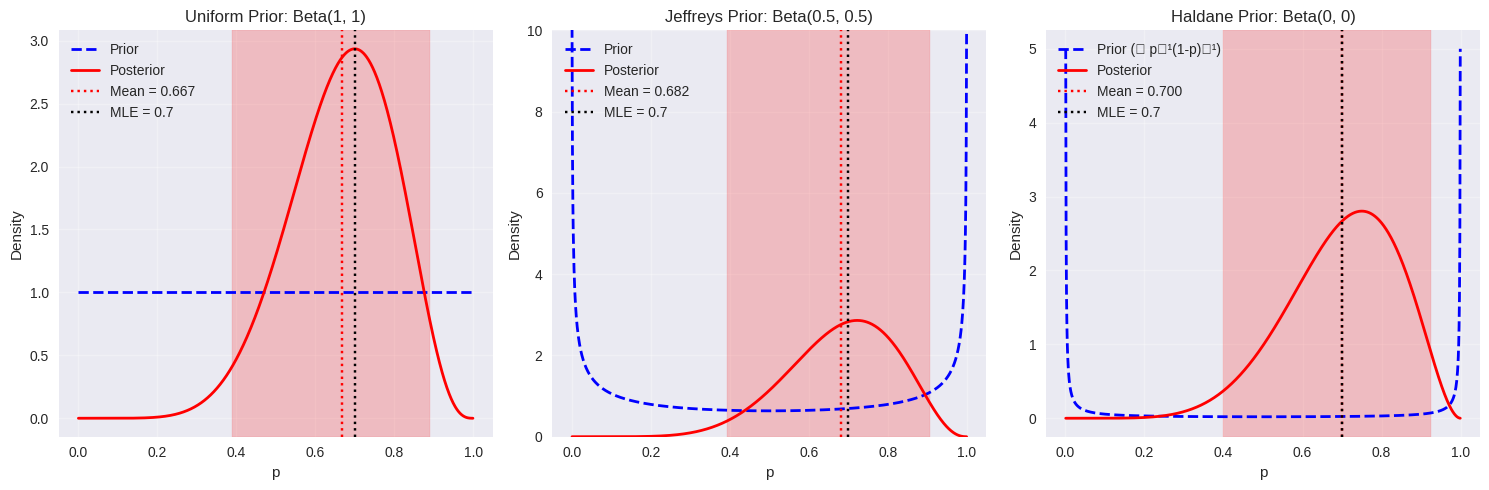

Posterior Summary (7 successes in 10 trials):
Prior		Posterior		Mean	95% CI
-------------------------------------------------------
Uniform     	Beta(8.0, 4.0)		0.667	[0.390, 0.891]
Jeffreys    	Beta(7.5, 3.5)		0.682	[0.394, 0.907]
Haldane     	Beta(7.0, 3.0)		0.700	[0.400, 0.925]

MLE: 0.700


In [5]:
# Compare different non-informative priors for binomial parameter
# Data: 7 successes out of 10 trials
successes, trials = 7, 10

# Different priors
priors = {
    'Uniform': (1, 1),           # Beta(1,1)
    'Jeffreys': (0.5, 0.5),     # Beta(1/2, 1/2)
    'Haldane': (0, 0),          # Beta(0, 0) - improper
}

x = np.linspace(0.001, 0.999, 1000)  # Avoid endpoints for Jeffreys

plt.figure(figsize=(15, 5))

for i, (name, (alpha, beta)) in enumerate(priors.items()):
    plt.subplot(1, 3, i+1)
    
    # Prior (handle improper case)
    if alpha > 0 and beta > 0:
        prior_dist = stats.beta(alpha, beta)
        plt.plot(x, prior_dist.pdf(x), 'b--', linewidth=2, label='Prior')
    elif name == 'Haldane':
        # Haldane prior is improper, plot proportional form
        prior_prop = x**(-1) * (1-x)**(-1)
        prior_prop = prior_prop / np.max(prior_prop[np.isfinite(prior_prop)]) * 5  # Scale for visibility
        plt.plot(x, prior_prop, 'b--', linewidth=2, label='Prior (∝ p⁻¹(1-p)⁻¹)')
    
    # Posterior
    alpha_post = alpha + successes
    beta_post = beta + trials - successes
    
    if alpha_post > 0 and beta_post > 0:
        posterior_dist = stats.beta(alpha_post, beta_post)
        plt.plot(x, posterior_dist.pdf(x), 'r-', linewidth=2, label='Posterior')
        
        # Statistics
        post_mean = posterior_dist.mean()
        ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
        
        plt.axvline(post_mean, color='red', linestyle=':', 
                   label=f'Mean = {post_mean:.3f}')
        plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='red')
    
    plt.axvline(successes/trials, color='black', linestyle=':', 
               label=f'MLE = {successes/trials:.1f}')
    
    plt.title(f'{name} Prior: Beta({alpha}, {beta})')
    plt.xlabel('p')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if name == 'Jeffreys':
        plt.ylim(0, 10)  # Limit y-axis for Jeffreys prior

plt.tight_layout()
plt.show()

# Compare posterior summaries
print("Posterior Summary (7 successes in 10 trials):")
print("Prior\t\tPosterior\t\tMean\t95% CI")
print("-" * 55)

for name, (alpha, beta) in priors.items():
    alpha_post = alpha + successes
    beta_post = beta + trials - successes
    
    if alpha_post > 0 and beta_post > 0:
        posterior_dist = stats.beta(alpha_post, beta_post)
        mean = posterior_dist.mean()
        ci_lower, ci_upper = posterior_dist.ppf([0.025, 0.975])
        
        print(f"{name:<12}\tBeta({alpha_post:.1f}, {beta_post:.1f})\t\t{mean:.3f}\t[{ci_lower:.3f}, {ci_upper:.3f}]")

print(f"\nMLE: {successes/trials:.3f}")

## 6. Prior Elicitation Techniques

### Methods for Choosing Priors:

1. **Historical Data**: Use previous studies or experiments
2. **Expert Opinion**: Elicit beliefs from domain experts
3. **Quantile Matching**: Match prior quantiles to expert beliefs
4. **Moment Matching**: Match prior moments to expert beliefs
5. **Maximum Entropy**: Choose prior that maximizes entropy subject to constraints

Expert beliefs:
- Most likely value: 15.0%
- 90% confident between 5.0% and 30.0%

Elicited prior: Beta(4.16, 20.64)
Prior mean: 0.168
Prior mode: 0.139
Prior 90% CI: [0.064, 0.303]


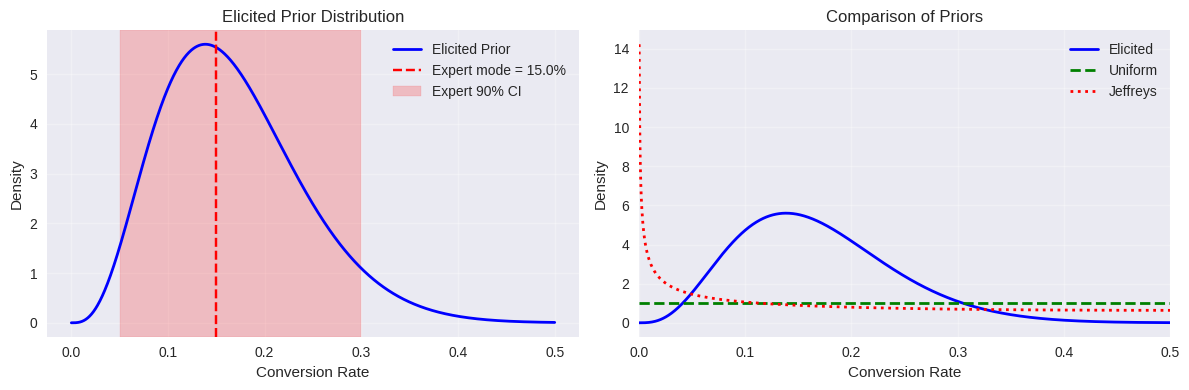


Observed data: 25 conversions out of 200 visitors (12.5%)
Elicited posterior mean: 0.130, 95% CI: [0.089, 0.177]
Uniform posterior mean: 0.129, 95% CI: [0.086, 0.178]
Jeffreys posterior mean: 0.127, 95% CI: [0.085, 0.176]


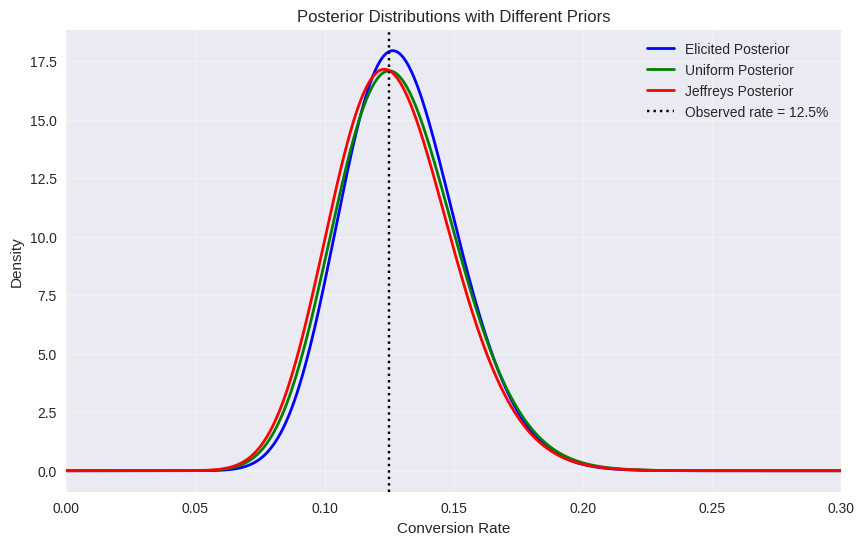

In [6]:
# Prior elicitation example: Expert believes conversion rate
# - Most likely around 15%
# - 90% confident it's between 5% and 30%

def elicit_beta_prior(mode, ci_lower, ci_upper, confidence=0.9):
    """
    Elicit Beta prior parameters from mode and credible interval
    """
    from scipy.optimize import minimize
    
    def objective(params):
        alpha, beta = params
        if alpha <= 0 or beta <= 0:
            return 1e10
        
        dist = stats.beta(alpha, beta)
        
        # Mode constraint: mode = (alpha-1)/(alpha+beta-2) for alpha,beta > 1
        if alpha > 1 and beta > 1:
            pred_mode = (alpha - 1) / (alpha + beta - 2)
            mode_error = (pred_mode - mode)**2
        else:
            mode_error = 1e10
        
        # Credible interval constraint
        tail_prob = (1 - confidence) / 2
        pred_ci_lower = dist.ppf(tail_prob)
        pred_ci_upper = dist.ppf(1 - tail_prob)
        
        ci_error = (pred_ci_lower - ci_lower)**2 + (pred_ci_upper - ci_upper)**2
        
        return mode_error + ci_error
    
    # Initial guess
    result = minimize(objective, [2, 10], method='Nelder-Mead')
    
    return result.x

# Expert beliefs
expert_mode = 0.15
expert_ci_lower = 0.05
expert_ci_upper = 0.30

print(f"Expert beliefs:")
print(f"- Most likely value: {expert_mode:.1%}")
print(f"- 90% confident between {expert_ci_lower:.1%} and {expert_ci_upper:.1%}")

# Elicit prior
alpha_elicit, beta_elicit = elicit_beta_prior(expert_mode, expert_ci_lower, expert_ci_upper)
elicited_prior = stats.beta(alpha_elicit, beta_elicit)

print(f"\nElicited prior: Beta({alpha_elicit:.2f}, {beta_elicit:.2f})")
print(f"Prior mean: {elicited_prior.mean():.3f}")
print(f"Prior mode: {(alpha_elicit-1)/(alpha_elicit+beta_elicit-2):.3f}")

# Verify credible interval
ci_check = elicited_prior.ppf([0.05, 0.95])
print(f"Prior 90% CI: [{ci_check[0]:.3f}, {ci_check[1]:.3f}]")

# Visualization
x = np.linspace(0, 0.5, 1000)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, elicited_prior.pdf(x), 'b-', linewidth=2, label='Elicited Prior')
plt.axvline(expert_mode, color='red', linestyle='--', label=f'Expert mode = {expert_mode:.1%}')
plt.axvspan(expert_ci_lower, expert_ci_upper, alpha=0.2, color='red', 
           label=f'Expert 90% CI')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Elicited Prior Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare with other priors
plt.subplot(1, 2, 2)
uniform_prior = stats.beta(1, 1)
jeffreys_prior = stats.beta(0.5, 0.5)

plt.plot(x, elicited_prior.pdf(x), 'b-', linewidth=2, label='Elicited')
plt.plot(x, uniform_prior.pdf(x), 'g--', linewidth=2, label='Uniform')
plt.plot(x, jeffreys_prior.pdf(x), 'r:', linewidth=2, label='Jeffreys')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Comparison of Priors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.5)

plt.tight_layout()
plt.show()

# Simulate impact on posterior with data
# Suppose we observe 25 conversions out of 200 visitors
conversions, visitors = 25, 200
observed_rate = conversions / visitors

print(f"\nObserved data: {conversions} conversions out of {visitors} visitors ({observed_rate:.1%})")

# Posteriors with different priors
posteriors = {
    'Elicited': stats.beta(alpha_elicit + conversions, beta_elicit + visitors - conversions),
    'Uniform': stats.beta(1 + conversions, 1 + visitors - conversions),
    'Jeffreys': stats.beta(0.5 + conversions, 0.5 + visitors - conversions)
}

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for i, (name, posterior) in enumerate(posteriors.items()):
    plt.plot(x, posterior.pdf(x), color=colors[i], linewidth=2, label=f'{name} Posterior')
    
    mean = posterior.mean()
    ci = posterior.ppf([0.025, 0.975])
    print(f"{name} posterior mean: {mean:.3f}, 95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

plt.axvline(observed_rate, color='black', linestyle=':', label=f'Observed rate = {observed_rate:.1%}')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Posterior Distributions with Different Priors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.3)
plt.show()

## 7. Sensitivity Analysis

### Importance of Checking Prior Sensitivity

Always check how sensitive your conclusions are to prior assumptions!

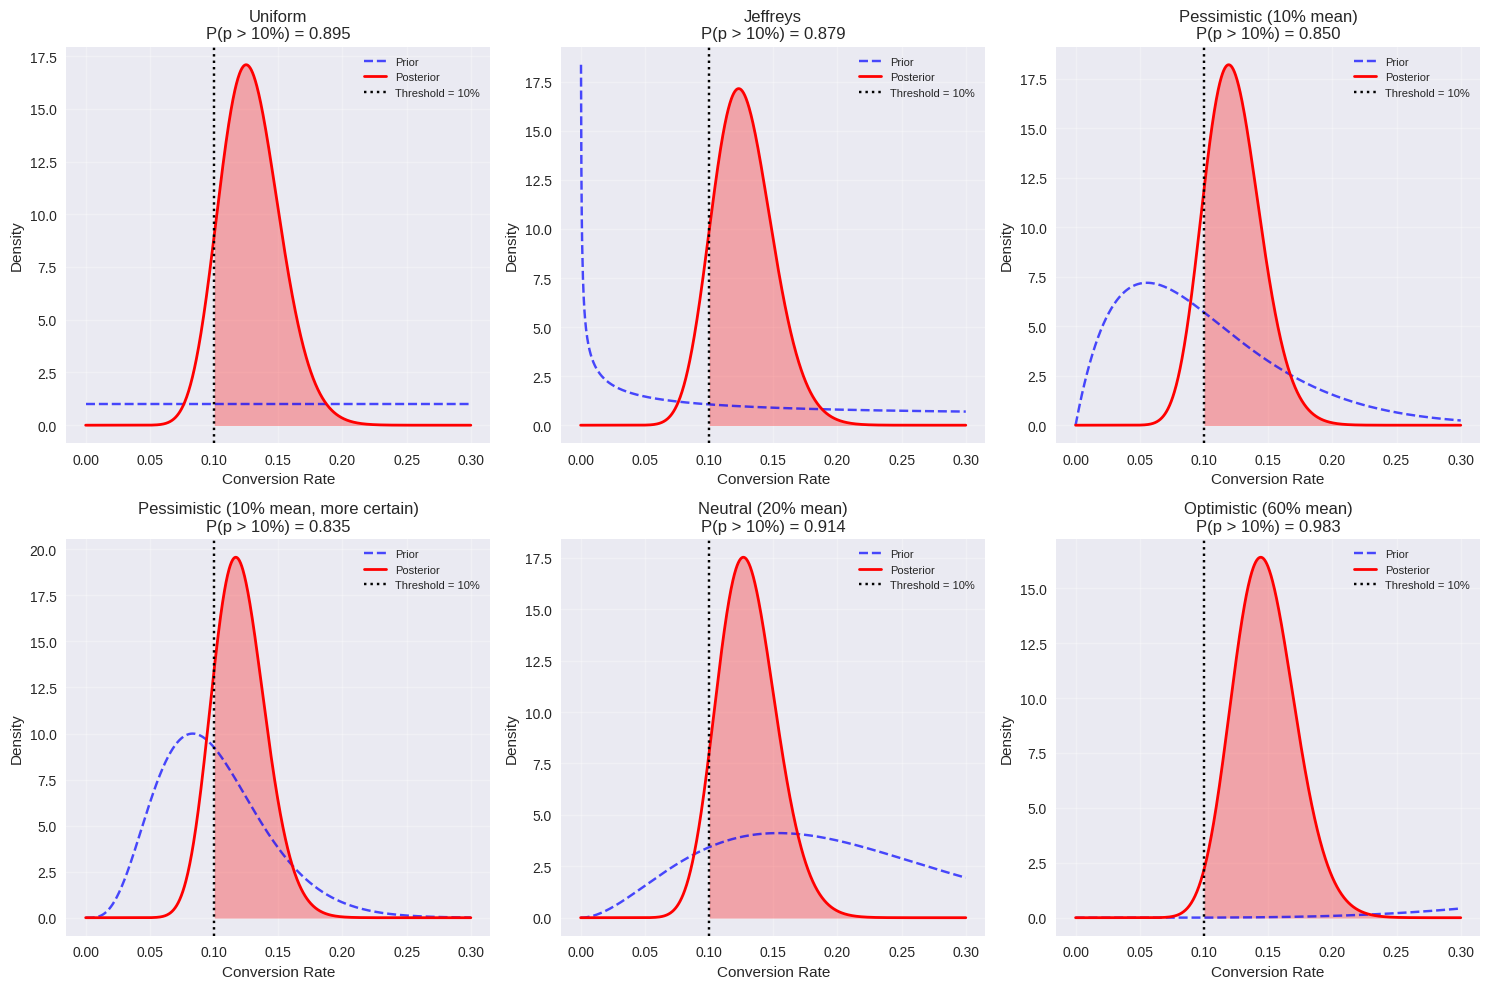

Sensitivity Analysis Results:
Prior				Prior Mean	Post Mean	P(p > 10%)
----------------------------------------------------------------------
Uniform                  	0.500		0.129		0.895
Jeffreys                 	0.500		0.127		0.879
Pessimistic (10% mean)   	0.100		0.123		0.850
Pessimistic (10% mean, more certain)	0.100		0.120		0.835
Neutral (20% mean)       	0.200		0.130		0.914
Optimistic (60% mean)    	0.600		0.148		0.983

Decision Analysis (using 80% threshold for 'strong evidence'):
Uniform                  : Strong evidence that p > 10%
Jeffreys                 : Strong evidence that p > 10%
Pessimistic (10% mean)   : Strong evidence that p > 10%
Pessimistic (10% mean, more certain): Strong evidence that p > 10%
Neutral (20% mean)       : Strong evidence that p > 10%
Optimistic (60% mean)    : Strong evidence that p > 10%


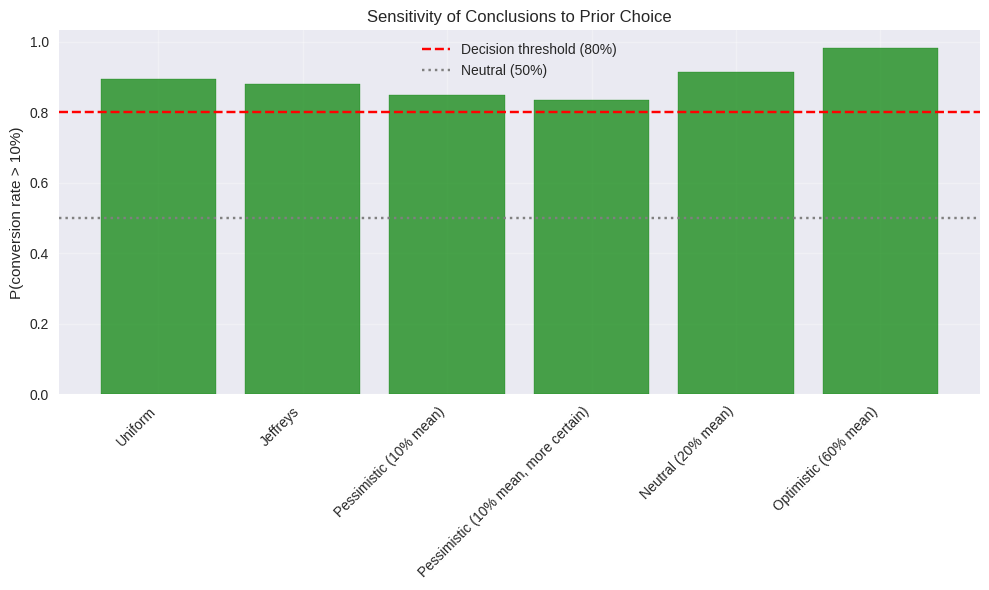

In [7]:
# Sensitivity analysis: How do different priors affect conclusions?
# Question: Is the conversion rate > 10%?

# Data: 25 conversions out of 200 visitors
conversions, visitors = 25, 200
threshold = 0.10

# Range of Beta priors to test
prior_specs = [
    (1, 1, 'Uniform'),
    (0.5, 0.5, 'Jeffreys'),
    (2, 18, 'Pessimistic (10% mean)'),
    (5, 45, 'Pessimistic (10% mean, more certain)'),
    (3, 12, 'Neutral (20% mean)'),
    (6, 4, 'Optimistic (60% mean)'),
]

results = []

plt.figure(figsize=(15, 10))

for i, (alpha, beta, name) in enumerate(prior_specs):
    # Prior
    prior = stats.beta(alpha, beta)
    
    # Posterior
    alpha_post = alpha + conversions
    beta_post = beta + visitors - conversions
    posterior = stats.beta(alpha_post, beta_post)
    
    # Probability > threshold
    prob_exceed = 1 - posterior.cdf(threshold)
    
    # Store results
    results.append({
        'name': name,
        'prior_mean': prior.mean(),
        'posterior_mean': posterior.mean(),
        'prob_exceed': prob_exceed
    })
    
    # Plot
    plt.subplot(2, 3, i+1)
    x = np.linspace(0, 0.3, 1000)
    
    plt.plot(x, prior.pdf(x), 'b--', alpha=0.7, label='Prior')
    plt.plot(x, posterior.pdf(x), 'r-', linewidth=2, label='Posterior')
    plt.axvline(threshold, color='black', linestyle=':', label=f'Threshold = {threshold:.0%}')
    
    # Shade area > threshold
    x_shade = x[x >= threshold]
    y_shade = posterior.pdf(x_shade)
    plt.fill_between(x_shade, y_shade, alpha=0.3, color='red')
    
    plt.title(f'{name}\nP(p > {threshold:.0%}) = {prob_exceed:.3f}')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("Sensitivity Analysis Results:")
print("Prior\t\t\t\tPrior Mean\tPost Mean\tP(p > 10%)")
print("-" * 70)

for result in results:
    print(f"{result['name']:<25}\t{result['prior_mean']:.3f}\t\t{result['posterior_mean']:.3f}\t\t{result['prob_exceed']:.3f}")

# Decision sensitivity
print(f"\nDecision Analysis (using 80% threshold for 'strong evidence'):")
for result in results:
    decision = "Strong evidence" if result['prob_exceed'] > 0.8 else "Weak evidence"
    print(f"{result['name']:<25}: {decision} that p > 10%")

# Visualize sensitivity
plt.figure(figsize=(10, 6))
names = [r['name'] for r in results]
probs = [r['prob_exceed'] for r in results]

bars = plt.bar(range(len(names)), probs, alpha=0.7)
plt.axhline(0.8, color='red', linestyle='--', label='Decision threshold (80%)')
plt.axhline(0.5, color='gray', linestyle=':', label='Neutral (50%)')

# Color bars based on decision
for i, (bar, prob) in enumerate(zip(bars, probs)):
    if prob > 0.8:
        bar.set_color('green')
    elif prob < 0.2:
        bar.set_color('red')
    else:
        bar.set_color('orange')

plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel('P(conversion rate > 10%)')
plt.title('Sensitivity of Conclusions to Prior Choice')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Key Takeaways

### Conjugate Priors:
- **Advantages**: Analytical solutions, computational efficiency, interpretability
- **Disadvantages**: Limited flexibility, may not reflect true beliefs
- **Use when**: Computational efficiency is important, prior beliefs align with conjugate family

### Non-informative Priors:
- **Jeffreys priors**: Invariant under reparameterization
- **Reference priors**: Maximize expected information
- **Caution**: "Non-informative" doesn't mean "no impact"

### Prior Elicitation:
- **Expert knowledge**: Valuable but subjective
- **Historical data**: Objective but may not be relevant
- **Sensitivity analysis**: Always check robustness

### Best Practices:
1. **Justify prior choice**: Document reasoning
2. **Check sensitivity**: Test multiple reasonable priors
3. **Use weakly informative priors**: When in doubt, use priors that provide some regularization but let data dominate
4. **Consider computational trade-offs**: Conjugacy vs. flexibility

## Exercises

1. **Conjugate Analysis**: A Poisson process has rate λ. Using a Gamma(2, 0.5) prior, you observe counts [3, 1, 4, 2, 5] in 5 time periods. Find the posterior distribution and 95% credible interval.

2. **Prior Elicitation**: An expert believes a new drug's success rate is "around 70% but could reasonably be anywhere from 50% to 85%". Elicit an appropriate Beta prior.

3. **Sensitivity Analysis**: Compare conclusions about whether a coin is fair (p = 0.5) using uniform, Jeffreys, and Beta(10, 10) priors after observing 15 heads in 20 flips.

4. **Normal-Normal**: Heights are normally distributed with known σ = 6 cm. Using prior N(170, 8²), you measure heights [165, 172, 168, 175, 170]. Find the posterior and predictive distributions.

## Next: Topic 3 - Estimation and Loss Functions

In the next notebook, we'll explore:
- Bayesian point estimation
- Loss functions and decision theory
- Credible intervals vs. confidence intervals
- Bayesian hypothesis testing foundations